# Smartcrop

There is often a need to crop many images to a standard size for printing, publication, or otherwise. While it is possible to manually crop images as desired on standard word processors and photo editting softwares, this process is tedious when you may want to resize many images at once. `smartcrop` utilizes face- and edge- detection computer vision algorithms to automatedly resize and crop images to a user-defined size, such that the image key features, aspect ratio, and resolution are preserved.

When resizing an image there are three main criteria to maintain in the cropped image:
<ul>
    <li>Key Features: the cropped image should contain the focus point(s) of the original image. These focus 
          points may be objects, faces, or both. The location of these focus points may also vary from image to 
        image. In a portrait image, the focus point may be in the center. But in a candid image, the location of 
        the focus point is more unpredictable.</li>
      <li>Aspect Ratio: the initial width : height dimensions should be preserved in the new image. </li>
      <li>Resolution: the cropped image should maintain the initial pixel resolution.</li>
</ul>

When resizing an image, if the original image aspect ratio differs from the cropped image aspect ratio, the image must be cropped in at least one dimension (width-wise or height-wise) to attain the new dimensions. Then the image may be cropped to fit the desired dimensions. Below is a schematic of this process:

<img src="smartcrop_testfiles/smartcrop-algorithm-schematic.png" style="width:1000px;height:550px;">

# Key Feature Detection Using OpenCV

`OpenCV` is an open source library of computer vision algorithms. We will use two algorithms from the OpenCV library for key feature detection in our images. We will also import the numpy and matplotlib libraries for matrix representation of images and visualization.

In [189]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import PIL as Image

Images may be composed of faces, objects, or both. Therefore, we would like our algorithm to detect faces and central objects in the image and decide which features are most prominent to include in the cropped image. To do this, we will explore two computer vision algorithms: the Viola-Jones face detection algorithm and the ORB edge detection algorithm.

### Viola-Jones Face Detection

The Viola-Jones face detection algorithm compares features an image with 'Haar Features'. Haar features are low-level pixel patterns, as shown below. Haar features are very similar to convolutional kernels.

<img src="smartcrop_testfiles/haar_features.jpg">

Using haar features we may represent features in a face. Edge features are similar to the contrast observed in eyebrows and mouth, whereas line features are similar to the contrast observed on the nose.

<img src="smartcrop_testfiles/haarfeatureexample.jpg" style="width:500;height:250px;">

The Viola-Jones algorithm compares the pixel intensities of an actual image features with those of an ideal haar feature, to evaluate whether a haar feature was detected.

<img src="smartcrop_testfiles/violajonesformula.png">

The haar cascade is an advanced deep learning algorithm that can be trained to detect haar features in an image, based on minimizing the viola jones value for each feature in the image. We will use OpenCV's pre-trained haar cascade for facial detection.

In [32]:
face_cascade = cv2.CascadeClassifier('path/to/haarcascade_frontalface_alt.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade

<CascadeClassifier 0x12f0013b0>

First let's read in three images to test our code with. The first image is one of a group of individuals, the second is of the NYC skyline, and the third is of a stadium with a crowd of people.

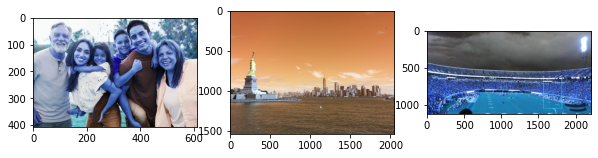

In [191]:
face_image = cv2.imread('smartcrop_testfiles/portrait.jpg')
skyline_image = cv2.imread('smartcrop_testfiles/statueofliberty.jpg')
stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 3, 1)
plt.imshow(face_image)
fig.add_subplot(1, 3, 2)
plt.imshow(skyline_image)
fig.add_subplot(1, 3, 3)
plt.imshow(stadium_image)

Let's run the Haar cascade on both images. `detectMultiScale` runs the classification algorithm on the image and returns a matrix of bounding boxes for every detected face. 

In [111]:
def detect_faces(img):
    # First convert image to grayscale
    img_BW = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Run detection algorithm
    detected_faces = face_cascade.detectMultiScale(img_BW)
    return detected_faces

def visualize_detected_faces(img, detected_faces):
    # Visualize detected faces
    temp = np.zeros(img.shape)
    temp = img
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(
            temp,
            (column, row),
            (column + width, row + height),
            (0, 255, 0),
            10
        )
    return temp

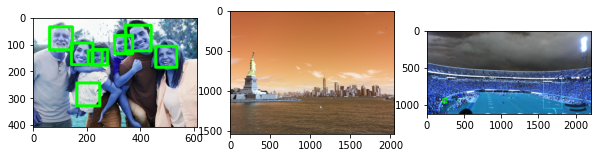

In [112]:
fig = plt.figure(figsize=(10,20))
face_detected_faces = detect_faces(face_image)
fig.add_subplot(1, 3, 1)
plt.imshow(visualize_detected_faces(face_image,face_detected_faces))

skyline_detected_faces = detect_faces(skyline_image)
fig.add_subplot(1, 3, 2)
plt.imshow(visualize_detected_faces(skyline_image,skyline_detected_faces))

stadium_detected_faces = detect_faces(stadium_image)
fig.add_subplot(1, 3, 3)
plt.imshow(visualize_detected_faces(stadium_image,stadium_detected_faces))

When looking into what the algorithm returned for each image, we see that for the image with multiple faces, there is one false positive. For the image of the stadium crow there is one false positive. However, for the image of the skyline , no faces are detected as we would expect.

In [98]:
face_detected_faces

array([[ 61,  36,  85,  85],
       [343,  30,  95,  95],
       [302,  68,  67,  67],
       [142,  96,  80,  80],
       [455, 108,  78,  78],
       [218, 120,  58,  58],
       [204, 123,  52,  52],
       [162, 244,  85,  85]], dtype=int32)

In [89]:
skyline_detected_faces

()

In [90]:
stadium_detected_faces

array([[211, 913,  54,  54]], dtype=int32)

A parameter we can control in the `detectMultiScale` function is the `minNeighbors`. As you increase the minNeighbors parameter, the stricter the face detection is. Let's modify our `detect_faces` function to incorporate this parameter.

In [114]:
def detect_faces(img,minNeighbors):
    # First convert image to grayscale
    img_BW = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Run detection algorithm
    detected_faces = face_cascade.detectMultiScale(img_BW,minNeighbors=minNeighbors)
    return detected_faces

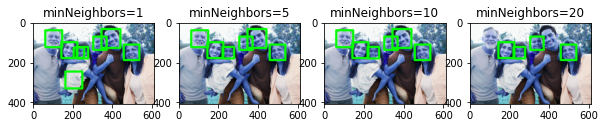

In [108]:
fig = plt.figure(figsize=(10,20))
face_image = cv2.imread('smartcrop_testfiles/portrait.jpg')
face_detected_faces_1 = detect_faces(face_image,1)
fig.add_subplot(1, 4, 1,title="minNeighbors=1")
plt.imshow(visualize_detected_faces(face_image,face_detected_faces))

face_image = cv2.imread('smartcrop_testfiles/portrait.jpg')
face_detected_faces_5 = detect_faces(face_image,5)
fig.add_subplot(1, 4, 2,title="minNeighbors=5")
plt.imshow(visualize_detected_faces(face_image,face_detected_faces_5))

face_image = cv2.imread('smartcrop_testfiles/portrait.jpg')
face_detected_faces_10 = detect_faces(face_image,10)
fig.add_subplot(1, 4, 3,title="minNeighbors=10")
plt.imshow(visualize_detected_faces(face_image,face_detected_faces_10))

face_image = cv2.imread('smartcrop_testfiles/portrait.jpg')
face_detected_faces_20 = detect_faces(face_image,20)
fig.add_subplot(1, 4, 4,title="minNeighbors=20")
plt.imshow(visualize_detected_faces(face_image,face_detected_faces_20))

For the image with clearly identifiable faces, the number of identified faces decreases as the min neighbors increases. We can see that after minNeighbors passes a certain threshold we can eliminate false positives and as minNeighbors passes a greater threshold we introduce false negatives. Based on the images above 5 <= minNeighbors <= 10 seems to be a good range for minNeighbors.

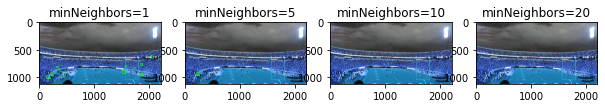

In [115]:
fig = plt.figure(figsize=(10,20))
stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')
stadium_detected_faces_1 = detect_faces(stadium_image,1)
fig.add_subplot(1, 4, 1,title="minNeighbors=1")
plt.imshow(visualize_detected_faces(stadium_image,stadium_detected_faces_1))

stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')
stadium_detected_faces_5 = detect_faces(stadium_image,5)
fig.add_subplot(1, 4, 2,title="minNeighbors=5")
plt.imshow(visualize_detected_faces(stadium_image,stadium_detected_faces_5))

stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')
stadium_detected_faces_10 = detect_faces(stadium_image,10)
fig.add_subplot(1, 4, 3,title="minNeighbors=10")
plt.imshow(visualize_detected_faces(stadium_image,stadium_detected_faces_10))

stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')
stadium_detected_faces_20 = detect_faces(stadium_image,20)
fig.add_subplot(1, 4, 4,title="minNeighbors=20")
plt.imshow(visualize_detected_faces(stadium_image,stadium_detected_faces_20))

For the image of the crowded stadium, we see that minNeighbors=10 eliminates false positives. Thus we can set minNeighbors = 10 as an optimal point for the face detection algorithm to accurately detect faces in images with faces, and to detect zero faces in images without faces.

### ORB Edge Detection

For images without identified faces, we will need to identify key objects. The ORB edge detection algorithm automatedly detects points within the image where there is very high contrast. These points will often outline the focus points of an object in an image. 

In [166]:
# instantiate ORB classifier
orb = cv2.ORB_create()

Let's define a function to use the ORB classifier on our images.

In [167]:
def detect_edges(img):
    kp = orb.detect(img, None)
    kp, des = orb.compute(img, kp)
    return kp

def visialize_edges(img,kp):
    img2 = np.zeros(img.shape)
    img2 = cv2.drawKeypoints(img,kp,img2,color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img2),plt.show()

Let's run ORB edge detection on the skyline and crowd images.

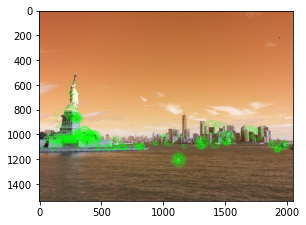

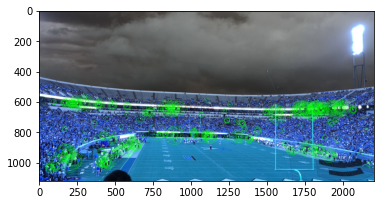

In [171]:
skyline_image = cv2.imread('smartcrop_testfiles/statueofliberty.jpg')
stadium_image = cv2.imread('smartcrop_testfiles/crowd.jpg')

fig = plt.figure(figsize=(10,20))
kp_skyline = detect_edges(skyline_image)
fig.add_subplot(1,2,1)
visialize_edges(skyline_image,kp_skyline)

kp_stadium = detect_edges(stadium_image)
fig.add_subplot(1,2,2)
visialize_edges(stadium_image,kp_stadium)

The ORB algorithm effectively supplies points across the image that are considered "edges". Defining a bounding box containing all these edges would ensure that the highlights of the original image are captured in the cropped image.

### Combining Viola Jones Face Detection and ORB Edge Detection

To create a single algorithm that detects the key points of the image we will combine the face detection and edge detection algorithms described above. We can first check to see if there are any faces. If there are no faces detected, we can revert to edge detection. The algorithm will return the bounding box of the identified points by the computer vision functions.

In [177]:
def get_kp(im):
    img = np.array(im.convert('RGB'))
    img_BW = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(img_BW,minNeighbors=10)
    if len(detected_faces) > 0:
        min_col = min(detected_faces[:,0])
        max_col = max(detected_faces[:,0] + detected_faces[:,2])
        min_row = min(detected_faces[:,1])
        max_row = max(detected_faces[:,1] + detected_faces[:,3])
    else:
        kp = orb.detect(img, None)
        kp, des = orb.compute(img, kp)
        kp = [list(i.pt) for i in kp]
        kp = np.array(kp)
        min_col = min(kp[:,0])
        max_col = max(kp[:,0])
        min_row = min(kp[:,1])
        max_row = max(kp[:,1])
    return [min_col,max_col,min_row,max_row]

# Putting it all together

We will use the python image-processing library, `PIL`, for resizing, cropping, and saving the images.

In [178]:
from PIL import Image

The `resize` and `crop` methods are used from the PIL library to resize and crop images. For image resizing the resampling method Image.LANCZOS is used to maintain image resolution as much as possible. To maintain image resolution the `save` method can be used and the file type and quality parameters may be adjusted to optimize image quality.

In [179]:
def image_resize_focal(im,w_new,h_new):    
    [w,h] = im.size
    if w/h >= w_new/h_new:
        # shrink the height
        x = int((h_new/h)*w)
        y = h_new
        im_new = im.resize((x,y),resample=Image.LANCZOS)

        # get the keypoints
        kp = get_kp(im_new)

         # crop the width
        mp_kp = (kp[0] + kp[1]) / 2
        col_1_crop = mp_kp - w_new / 2 
        col_2_crop = mp_kp + w_new / 2
        if col_1_crop <= 0:
            col_1_crop = 0
            col_2_crop = w_new
        if col_2_crop >= w:
            col_2_crop = w
            col_1_crop = w - w_new
        im_ret = im_new.crop((col_1_crop, 0, col_2_crop, h_new)) 
    else:
        # shrink the width
        x = w_new
        y = int((w_new/w)*h)
        im_new = im.resize((x,y),resample=Image.LANCZOS)

        # get the keypoints
        kp = get_kp(im_new)

        # crop the height
        mp_kp = (kp[2] + kp[3]) / 2
        row_1_crop = mp_kp - h_new / 2
        row_2_crop = mp_kp + h_new / 2
        if row_1_crop <= 0:
            row_1_crop = 0
            row_2_crop = h_new
        if row_2_crop >= h:
            row_2_crop = h
            row_1_crop = h - h_new
        im_ret = im_new.crop((0, row_1_crop, w_new, row_2_crop))
    return im_ret

# Cropped Examples

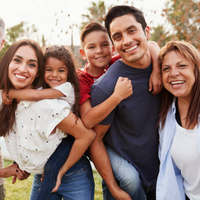

In [185]:
face_image = Image.open('smartcrop_testfiles/portrait.jpg')
skyline_image = Image.open('smartcrop_testfiles/statueofliberty.jpg')
stadium_image = Image.open('smartcrop_testfiles/crowd.jpg')

image_resize_focal(face_image,200,200)

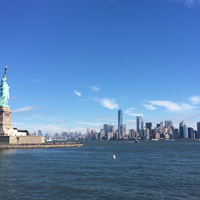

In [182]:
image_resize_focal(skyline_image,200,200)

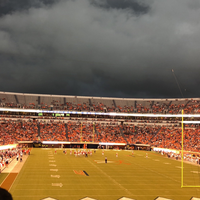

In [183]:
image_resize_focal(stadium_image,200,200)